In [1]:
import os
os.chdir('libraries for functions')

In [2]:
import os
os.chdir('pyimagesearch')

In [17]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras import datasets, layers, models
import datetime
from keras.layers import Dense, LSTM, GRU, Activation, Conv1D
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import calendar
import datetime as dt
from datetime import timedelta, date
from pprint import pprint

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import joblib
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Dense, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate
from tensorflow.keras.regularizers import l2
import pickle

from scipy.stats import randint as sp_randint
from time import time
import pickle

import warnings
warnings.filterwarnings('ignore')

In [18]:
from timeseires.CNN1D.GoogLeNet1D import PC
from timeseires.utils.to_split import to_split
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Dense, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate
from tensorflow.keras.regularizers import l2
import pickle

In [19]:
time_steps=72
num_features=14

In [20]:
def lstm():
    inputs = Input(shape=(time_steps, num_features))
    x = Conv1D(128, kernel_size=3,  activation='relu')(inputs)
    x = GRU(48, return_sequences=True)(x)
    x = GRU(32, return_sequences=True)(x)
    x = GRU(16)(x)
    x = Dense(10)(x)
    x = Activation("relu")(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    return model

In [21]:
model = lstm()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 72, 14)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 70, 128)           5504      
                                                                 
 gru_6 (GRU)                 (None, 70, 48)            25632     
                                                                 
 gru_7 (GRU)                 (None, 70, 32)            7872      
                                                                 
 gru_8 (GRU)                 (None, 16)                2400      
                                                                 
 dense_4 (Dense)             (None, 10)                170       
                                                                 
 activation_2 (Activation)   (None, 10)                0   

In [22]:
checkpoints = 'Ihsan_Final checkpoints for week 24_CNN-GRU/E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = 'Ihsan_Final checkpoints for week 24_CNN-GRU'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"history.json"])

In [23]:
model = None
start_epoch = 0
time_steps=72
num_features=14

In [24]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [25]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = lstm()
    opt = Adam(1e-4)
    model.compile(loss= 'mae', optimizer='adam', metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [26]:
df_tr=pd.read_csv('train_Normalized for week 24.csv')
train_set = df_tr[:].values 

In [27]:
df_v = pd.read_csv('validation_Normalized for week 24.csv')
validation_set = df_v[:].values

df_te = pd.read_csv('test_Normalized for week 24.csv')
test_set = df_te[:].values 
scaler = pickle.load(open("scaler.pkl", 'rb'))

In [28]:
start = time.time()
train_X , train_y = to_split(train_set, time_steps=time_steps, target_col=0, target_len=1)
validation_X, validation_y = to_split(validation_set, time_steps=time_steps, target_col=0, target_len=1)
test_X, test_y = to_split(test_set, time_steps=time_steps, target_col=0, target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.2648646831512451 sec


In [29]:
train_X.shape,validation_X.shape

((37502, 72, 14), (9322, 72, 14))

In [32]:
epochs = 50
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/50
1172/1172 [==============================] - ETA: 0s - loss: 0.0109 - mae: 0.0109 - mape: 17367.6660
Epoch 1: val_loss did not improve from 0.01426
1172/1172 [==============================] - 125s 103ms/step - loss: 0.0109 - mae: 0.0109 - mape: 17367.6660 - val_loss: 0.0146 - val_mae: 0.0146 - val_mape: 2.7937
Epoch 2/50
1172/1172 [==============================] - ETA: 0s - loss: 0.0110 - mae: 0.0110 - mape: 17257.9355
Epoch 2: val_loss did not improve from 0.01426
1172/1172 [==============================] - 126s 107ms/step - loss: 0.0110 - mae: 0.0110 - mape: 17257.9355 - val_loss: 0.0164 - val_mae: 0.0164 - val_mape: 3.1234
Epoch 3/50
1172/1172 [==============================] - ETA: 0s - loss: 0.0108 - mae: 0.0108 - mape: 17594.1660
Epoch 3: val_loss improved from 0.01426 to 0.01383, saving model to Ihsan_Final checkpoints for week 24_CNN-GRU/E1-cp-0003-loss0.01.h5
1172/1172 [==============================] - 125s 106ms/step - loss: 0.0108 - mae: 0.0108 - mape: 17594.1

In [33]:
import pickle
model = load_model('Ihsan_Final checkpoints for week 24_CNN-GRU/E1-cp-0003-loss0.01.h5')

In [34]:
y_pred_scaled   = model.predict(test_X)

3/3 [==============================] - 1s 17ms/step


In [35]:
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y.reshape(-1, 1))

In [36]:
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 19.82
Median Absolute Error (MedAE): 17.93
Mean Squared Error (MSE): 555.79
Root Mean Squared Error (RMSE): 23.58
Mean Absolute Percentage Error (MAPE): 1.76 %
Median Absolute Percentage Error (MDAPE): 1.57 %


y_test_unscaled.shape=  (96, 1)
y_pred.shape=  (96, 1)


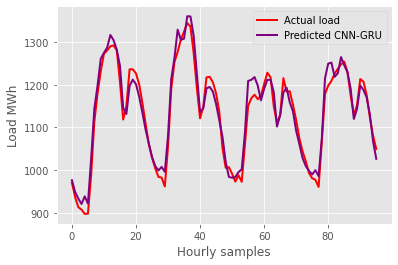

In [37]:
plt.plot(y_test_unscaled, color="red", linewidth=2)
plt.plot(y_pred, color="purple", linewidth=2)
plt.legend(['Actual load','Predicted CNN-GRU'])
plt.ylabel('Load MWh')
plt.xlabel('Hourly samples')
plt.show()